In [61]:
import os
import json
import numpy as np
import pandas as pd
import re
from google.colab import drive, userdata
import google.generativeai as genai

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# Inicializar config_data com configuração padrão
config_data = {
    "project_base_dir": os.path.abspath('SimClasIotIA/'),
    "feature_columns": ["distancia_cm", "velocidade_cm_s"],
    "label_column": "tipo_obstaculo",
    "obstacle_types": ["Pessoa", "Parede", "Objeto Pequeno", "Vazio"]
}
# Exemplo de configuração JSON para salvar em arquivo
example_config = {
    "project_base_dir": os.path.abspath('MyDrive/'),
    "feature_columns": ["distancia_cm", "velocidade_cm_s"],
    "label_column": "tipo_obstaculo",
    "obstacle_types": ["Pessoa", "Parede", "Objeto Pequeno", "Vazio"]
}

# Para salvar este exemplo em um arquivo, descomente as linhas abaixo
'''
with open('example_config.json', 'w') as f:
    json.dump(example_config, f, indent=2, ensure_ascii=False)
print("Arquivo de exemplo salvo como 'example_config.json'")
'''

# Definição manual de JSON (alternativa em caso de falha na extração)
manual_json = '''
{
  "project_base_dir": "/caminho/do/seu/projeto/",
  "feature_columns": ["distancia_cm", "velocidade_cm_s"],
  "label_column": "tipo_obstaculo",
  "obstacle_types": ["Pessoa", "Parede", "Objeto Pequeno", "Vazio"]
}
'''

# Para usar esta opção, descomente as linhas abaixo
# config_data = json.loads(manual_json)
# config_data['project_base_dir'] = project_base_dir_manual  # Use o caminho configurado pelo usuário
# print('Configuração definida manualmente:')
# display(config_data)

# 01_Geracao_Dados_Mock.ipynb

Este notebook realiza a coleta de requisitos via chat com IA Gemini, gera o arquivo de configuração do projeto e simula dados de sensores para projetos de séries temporais multivariadas.

**Instruções:**
- Monte seu Google Drive.
- Adapte o caminho base do projeto conforme sua estrutura.
- Configure sua chave de API Gemini nos Segredos do Colab (`GEMINI_API_KEY`).
- A interação com a API começa aqui.

In [62]:
# Instalar bibliotecas necessárias
!pip install numpy pandas google-generativeai

## Montagem do Google Drive
Monte seu Google Drive para salvar arquivos de configuração e dados.

In [63]:
# Montar Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Definição do caminho base do projeto
Adapte a string abaixo para o diretório desejado no seu Google Drive.

In [64]:
# Obter o diretório atual do notebook

# Verificar ambiente (Colab ou local)
try:
    # Se estiver no Colab
    from google.colab import drive
    IS_COLAB = True
    # O diretório base será definido depois de montar o Google Drive
    current_notebook_dir = None
except ImportError:
    # Se estiver em ambiente local
    IS_COLAB = False
    # Obtém o diretório atual onde o notebook está sendo executado
    current_notebook_dir = os.path.abspath('')
    print(f"Diretório atual do notebook: {current_notebook_dir}")

In [65]:
# Defina o diretório base do projeto (ADAPTE PARA O SEU CASO)
if IS_COLAB:
    # Sempre use um subdiretório do MyDrive para evitar erro de permissão
    project_base_dir_manual = '/content/drive/MyDrive/SimClasIotIA/'
    os.makedirs(project_base_dir_manual, exist_ok=True)
else:
    project_base_dir_manual = os.path.abspath('SimClasIotIA')
    os.makedirs(project_base_dir_manual, exist_ok=True)
print(f"Usando diretório base: {project_base_dir_manual}")

Usando diretório base: /content/drive/MyDrive/SimClasIotIA/


## Configuração segura da API Gemini
A chave de API Gemini deve ser salva nos Segredos do Colab com o nome `GEMINI_API_KEY`.

In [66]:
# Configurar API Gemini
from google.colab import userdata

API_KEY = userdata.get('GOOGLE_API_KEY')

if API_KEY is None:
    print("ERRO: Chave GEMINI_API_KEY não encontrada nos Segredos do Colab. Por favor, configure-a.")
else:
    try:
        genai.configure(api_key=API_KEY)
        print("Gemini API configurada com sucesso.")
    except Exception as e:
        print(f'ERRO ao configurar Gemini API: {e}')

Gemini API configurada com sucesso.


## Chat em duas fases com Gemini
Na Fase 1, o foco é entender a natureza e o contexto do sensor.

**Gatilho para encerrar digite:** `xpto`

# Verificar modelos disponíveis
if GEMINI_AVAILABLE:
    try:
        print("Modelos disponíveis:")
        for m in genai.list_models():
            print(m.name)
    except Exception as e:
        print(f"ERRO ao listar modelos Gemini: {e}")
else:
    print("Não foi possível listar modelos porque o Gemini API não está disponível.")

In [ ]:
# Fase 1: Coleta de contexto do sensor
phase1_complete_trigger = "xpto"
gemini_model_name = 'gemini-2.0-flash'

phase1_initial_prompt = f'''Aja como um cientista de daods experiente que está entrevistando um usuário leigo para coletar requisitos para simular dados de um sensor para um projeto IOT.
Seu foco é entender a NATUREZA e a FUNCIONALIDADE geral do sensor e o CONTEXTO onde ele será usado (ex: robô móvel, sistema de segurança, monitoramento ambiental).
Faça perguntas sobre que tipo de fenômeno físico o sensor mede (distância, luz, temperatura, movimento, etc.) e qual o ambiente de operação.
Ao final desta fase de entendimento do sensor e contexto, você deve perguntar ao usuário se ele considera que o CONTEXTO DO SENSOR ESTÁ DEFINIDO. Ele responderá "{phase1_complete_trigger}" para indicar que podemos seguir.
Não avance para perguntar sobre objetivos de detecção ainda.'''
chat = genai.GenerativeModel(model_name=gemini_model_name).start_chat(history=[])
response = chat.send_message(phase1_initial_prompt)
print("Iniciando Fase 1 do chat:")
print("IA:", response.text)

# Loop de interação Fase 1
while True:
    user_input = input('Você: ')
    if user_input == phase1_complete_trigger:
        print('Fase 1 concluída pelo usuário.')
        break
    response = chat.send_message(user_input)
    print('IA:', response.text)
print('...')

Iniciando Fase 1 do chat:
IA: Ok, vamos lá!

Olá! Obrigado por disponibilizar seu tempo para me ajudar com este projeto. Sou [Seu Nome], cientista de dados, e estou trabalhando na simulação de dados de sensores para o seu projeto de IoT. Para começar, preciso entender melhor o sensor que você pretende simular e o contexto em que ele será utilizado.

Primeiramente, poderia me dizer **qual é o tipo de fenômeno físico que o sensor mede?** Por exemplo, ele mede distância, luz, temperatura, movimento, pressão, umidade, qualidade do ar, ou algo diferente?

(Aguardando resposta)

Certo, e agora, pensando no **ambiente de operação do sensor**, onde ele será utilizado? Ele estará em um robô móvel, em um sistema de segurança, em uma área de monitoramento ambiental, dentro de uma máquina industrial, em um dispositivo vestível, ou em outro lugar?

(Aguardando resposta)

Excelente. Agora, um pouco mais de detalhe sobre o **ambiente**:

*   Se for um ambiente interno, qual o tamanho aproximado do es

### Interação do usuário na Fase 1
Digite suas respostas abaixo, linha por linha. Use a frase gatilho para encerrar a Fase 1.

## Fase 2: Objetivos de detecção/classificação
Agora, o foco é entender os objetivos de detecção/classificação e as características relevantes.

**Gatilho para pedir o JSON final:** `Gerar Config JSON agora`

In [ ]:
# Fase 2: Coleta de objetivos e características
phase2_complete_trigger = "Sim, fim do Config"
phase2_transition_prompt = f'''O usuário confirmou que a Fase 1 (contexto do sensor) está completa. Agora, mude seu foco.
Nesta Fase 2, seu objetivo é entender os OBJETIVOS de DETECÇÃO/CLASSIFICAÇÃO do usuário com este sensor. Pergunte quais TIPOS de situações ou 'obstáculos' o sistema deve identificar (ex: detectar pessoas, identificar portas abertas/fechadas, diferenciar objetos grandes de pequenos, notar mudanças ambientais).
Com base nas respostas do usuário, você deve inferir quais CARACTERÍSTICAS (features) *derivadas dos dados do sensor* serão relevantes para classificar esses objetivos. Ex: se o sensor mede distância, a 'velocidade de aproximação' ou 'tamanho percebido' podem ser características relevantes. Se mede temperatura, a 'taxa de variação da temperatura' pode ser relevante.
Ao final desta fase, quando o usuário disser exatamente "{phase2_complete_trigger}", você deve gerar APENAS um objeto JSON com a configuração final, sem texto adicional. O JSON deve estar formatado em uma única linha sem quebras de linha adicionais, e usar aspas duplas para chaves e strings.
O JSON deve ter o formato:  {{"project_base_dir": "/caminho/definir/usuario/", "feature_columns": ["nome_caracteristica_1", "nome_caracteristica_2"], "label_column": "tipo_obstaculo", "obstacle_types": ["Nome Obstáculo 1", "Nome Obstáculo 2"]}}
Use nomes de características e obstáculos baseados na conversa. Use "/caminho/definir/usuario/" como valor para project_base_dir.
Comece perguntando sobre os objetivos de detecção.'''
response = chat.send_message(phase2_transition_prompt)
print('Iniciando Fase 2 do chat:')
print('IA:', response.text)

# Loop de interação Fase 2
final_ai_response = ''
json_requested = False
while True:
    user_input = input('Você: ')

    # Verificar se o usuário solicitou o JSON
    if phase2_complete_trigger in user_input:
        json_requested = True
        print('Gatilho para JSON detectado na entrada do usuário.')
        # Adicionar lembrete explícito para a IA gerar apenas o JSON
        user_input = f"{user_input} - Por favor, gere APENAS o objeto JSON conforme formato especificado, sem comentários ou texto adicional."

    # Enviar mensagem para a IA
    response = chat.send_message(user_input)
    print('IA:', response.text)

    # Guardar a resposta final sempre (garantindo que tenhamos o conteúdo mais recente)
    final_ai_response = response.text

    # Sair do loop se o JSON for solicitado
    if json_requested:
        print('='*50)
        print('RESPOSTA FINAL RECEBIDA:')
        print('='*50)
        print(final_ai_response)
        print('='*50)
        print('Finalizando fase de chat e extraindo JSON...')
        break

print('Chat concluído. Processando resposta final...')

Iniciando Fase 2 do chat:
IA: Entendido! Fase 2 iniciada: Objetivos de Detecção e Classificação.

Agora que temos os cenários definidos, vamos nos aprofundar nos objetivos específicos de detecção/classificação. Quais *tipos* de situações ou obstáculos o sistema precisa *identificar* ou *diferenciar* usando os dados do sensor?

Por exemplo:

*   O sistema precisa *detectar a presença* de pessoas?
*   Precisa *diferenciar* entre obstáculos estáticos (postes, lixeiras) e obstáculos dinâmicos (pessoas, animais)?
*   Precisa *identificar* o tipo de superfície à frente (calçada, rua, grama)?
*   Precisa *notar mudanças ambientais* como a presença de uma poça d'água?
*   Precisa *diferenciar* objetos grandes de pequenos?

Quais desses objetivos são mais importantes para o seu sistema, e existem outros que você gostaria de adicionar?

Você: O sistema precisa *detectar a presença* de pessoas,  Precisa *diferenciar* entre obstáculos estáticos e Precisa *diferenciar* objetos grandes de pequenos? 

### Interação do usuário na Fase 2
Digite suas respostas abaixo. Use a frase gatilho para pedir o JSON final.

In [67]:
# Visualizar resposta final da IA que será usada para extrair o JSON
from IPython.display import display, Markdown
import json as pyjson
import re

if isinstance(final_ai_response, dict):
    display(final_ai_response)
else:
    try:
        # Tenta extrair JSON da string
        json_string = re.search(r'\{.*\}', final_ai_response, re.DOTALL).group(0)
        parsed = pyjson.loads(json_string)
        display(Markdown(f'```json\n{pyjson.dumps(parsed, indent=2, ensure_ascii=False)}\n```'))
    except Exception:
        display(Markdown(f'````\n{final_ai_response}\n````'))

```json
{
  "project_base_dir": "/caminho/definir/usuario/",
  "feature_columns": [
    "Distancia",
    "Variacao da Distancia",
    "Tamanho Percebido",
    "Velocidade de Aproximacao",
    "Frequencia de Deteccao"
  ],
  "label_column": "tipo_obstaculo",
  "obstacle_types": [
    "Pessoa",
    "Obstaculo Estatico",
    "Obstaculos pequenos e medios"
  ]
}
```

## Extração do JSON de configuração
O código abaixo tentará extrair e validar o JSON da resposta final da IA.

## Carregar JSON de arquivo existente
Você pode carregar uma configuração existente de um arquivo JSON no ambiente local, útil quando estiver executando o notebook sem acesso à API Gemini.

## Opção de JSON manual para recuperação
Se a extração do JSON da resposta do Gemini falhar, você pode utilizar esta opção manual abaixo.

In [68]:
# Extração e validação do JSON
fallback_config_data = {
    'project_base_dir': project_base_dir_manual,
    'feature_columns': ['distancia_cm'],
    'label_column': 'tipo_obstaculo',
    'obstacle_types': ['Default Obstacle']
}
config_data = None
try:
    # Verificar se temos uma resposta final para processar
    if not final_ai_response or final_ai_response.strip() == '':
        print('ERRO: Resposta final da IA está vazia.')
    else:
        # Procurar por padrão que se parece com JSON entre chaves
        # Pattern melhorado para ser mais robusto
        json_string_match = re.search(r'\{[^{}]*((\{[^{}]*\})|[^{}])*\}', final_ai_response, re.DOTALL)
        if json_string_match:
            json_string = json_string_match.group(0)
            print('\nJSON encontrado na resposta:')
            print(json_string)
            # Tenta parsear o JSON
            config_data = json.loads(json_string)
            print('\nJSON extraído e parseado com sucesso.')
        else:
            print('ERRO: Objeto JSON não encontrado na resposta final da IA.')
            print('Conteúdo da resposta:')
            print(final_ai_response)

            # Tentativa alternativa: procurar por chaves individuais e construir o JSON
            feature_match = re.search(r'"feature_columns"\s*:\s*\[(.*?)\]', final_ai_response)
            obstacle_match = re.search(r'"obstacle_types"\s*:\s*\[(.*?)\]', final_ai_response)
            label_match = re.search(r'"label_column"\s*:\s*"(.*?)"', final_ai_response)

            if feature_match and obstacle_match and label_match:
                # Tentar construir o JSON manualmente
                try:
                    feature_str = '[' + feature_match.group(1) + ']'
                    obstacle_str = '[' + obstacle_match.group(1) + ']'
                    features = json.loads(feature_str)
                    obstacles = json.loads(obstacle_str)
                    label = label_match.group(1)

                    config_data = {
                        'project_base_dir': project_base_dir_manual,
                        'feature_columns': features,
                        'label_column': label,
                        'obstacle_types': obstacles
                    }
                    print('\nJSON construído manualmente a partir dos fragmentos encontrados.')
                except Exception as e:
                    print(f'Erro ao tentar construir JSON manualmente: {e}')

except json.JSONDecodeError as e:
    print(f'ERRO: Falha ao parsear JSON da resposta da IA: {e}')
    print(f'Texto que causou o erro: {json_string if "json_string" in locals() else "N/A"}')
    # Tenta limpar o JSON removendo texto extra
    if "json_string" in locals():
        clean_json = re.sub(r'[^{}\[\]:,"0-9a-zA-Z_\-\.\s]', '', json_string)
        try:
            config_data = json.loads(clean_json)
            print('JSON limpo e parseado com sucesso após remoção de caracteres inválidos.')
        except:
            print('Falha ao parsear JSON mesmo após limpeza.')
except Exception as e:
    print(f'ERRO inesperado ao processar resposta da IA: {e}')

# Validar e completar config_data
if config_data and isinstance(config_data, dict):
    required_keys = ['feature_columns', 'obstacle_types', 'label_column']
    missing_keys = []
    for key in required_keys:
        if key not in config_data:
            missing_keys.append(key)
            print(f'Aviso: Chave {key} ausente no JSON gerado pela IA.')

    if missing_keys:
        print(f"Chaves ausentes: {missing_keys}. Usando valores padrão para as chaves ausentes.")
        for key in missing_keys:
            config_data[key] = fallback_config_data[key]

    config_data['project_base_dir'] = project_base_dir_manual
    print('\nConfiguração final obtida:')
    display(config_data)
else:
    print('Usando configuração de fallback devido a erro ou falta de JSON da IA.')
    config_data = fallback_config_data
    config_data['project_base_dir'] = project_base_dir_manual
    display(config_data)


JSON encontrado na resposta:
{"project_base_dir": "/caminho/definir/usuario/", "feature_columns": ["Distancia", "Variacao da Distancia", "Tamanho Percebido", "Velocidade de Aproximacao", "Frequencia de Deteccao"], "label_column": "tipo_obstaculo", "obstacle_types": ["Pessoa", "Obstaculo Estatico", "Obstaculos pequenos e medios"]}

JSON extraído e parseado com sucesso.

Configuração final obtida:


{'project_base_dir': '/content/drive/MyDrive/SimClasIotIA/',
 'feature_columns': ['Distancia',
  'Variacao da Distancia',
  'Tamanho Percebido',
  'Velocidade de Aproximacao',
  'Frequencia de Deteccao'],
 'label_column': 'tipo_obstaculo',
 'obstacle_types': ['Pessoa',
  'Obstaculo Estatico',
  'Obstaculos pequenos e medios']}

## Geração dos dados simulados
A partir deste ponto, o código usará o config_data para gerar dados simulados e salvar os arquivos.

In [69]:
# Criar diretório base do projeto
try:
    os.makedirs(project_base_dir_manual, exist_ok=True)
    print(f"Diretório base criado: {project_base_dir_manual}")
except Exception as e:
    print(f'ERRO ao criar diretório base: {e}')

# Definir nomes e caminhos dos arquivos de saída
config_output_filename = 'project_config.json'
data_output_filename = 'simulated_sensor_data.csv'
config_filepath = os.path.join(project_base_dir_manual, config_output_filename)
data_filepath = os.path.join(project_base_dir_manual, data_output_filename)

# Ajustar caminhos para ambiente Windows
if os.name == 'nt':  # Verificar se é Windows
    # Verificar se o caminho atual tem espaços ou caracteres especiais
    current_path = os.path.abspath('')
    if ' ' in current_path or any(c in current_path for c in '()[]{}áéíóúàèìòùâêîôûãõñç'):
        print("AVISO: O caminho atual contém espaços ou caracteres especiais:")
        print(current_path)
        print("\nPara melhor compatibilidade, considere criar uma pasta de projeto com nome simples.")

        # Sugerir pasta no usuário para o projeto
        simpler_path = os.path.join(os.path.expanduser("~"), "SimClasIotIA_Project")
        print(f"\nSugestão de caminho alternativo: {simpler_path}")

        # Perguntar se deseja usar o caminho alternativo
        print("\nPara usar o caminho alternativo, descomente e execute o código abaixo:")
        print(f"""# projeto_dir = "{simpler_path}"
# os.makedirs(projeto_dir, exist_ok=True)
# project_base_dir_manual = projeto_dir""")
    else:
        print("O caminho atual não contém espaços ou caracteres especiais. Bom para compatibilidade!")

# Lógica de geração de dados simulados
n_samples = 500  # Número de amostras a gerar
time_interval_seconds = 0.5  # Intervalo entre medições
noise_level = 0.1  # Nível de ruído (0 a 1)

# Verificar se temos as configurações mínimas
feature_columns = config_data.get('feature_columns', ['distancia'])
obstacle_types = config_data.get('obstacle_types', ['Default Obstacle'])
label_column = config_data.get('label_column', 'tipo_obstaculo')




# Gerar timestamp
np.random.seed(42)
start_time = pd.Timestamp('2025-01-01')
timestamps = [start_time + pd.Timedelta(seconds=i*time_interval_seconds) for i in range(n_samples)]

# Gerar dados para cada feature
data = {'timestamp': timestamps}
for feature in feature_columns:
    # Gerar valores base para cada tipo de obstáculo
    values = []
    current_obstacle = None
    for i in range(n_samples):
        # Mudar de obstáculo a cada ~50 amostras em média
        if i % 50 == 0 or current_obstacle is None:
            current_obstacle = np.random.choice(obstacle_types)

        # Gerar valor base dependendo do tipo de obstáculo (simulando características diferentes)
        obstacle_index = obstacle_types.index(current_obstacle)
        base_value = 100 + (obstacle_index * 20)  # Valores diferentes por tipo

        # Adicionar tendência e ruído
        trend = np.sin(i/50) * 10  # Tendência senoidal
        noise = np.random.normal(0, noise_level * base_value)  # Ruído proporcional
        values.append(base_value + trend + noise)

    data[feature] = values

# Gerar labels (obstáculos) com alguma correlação com os valores gerados
obstacle_data = []
for i in range(n_samples):
    # Determinar o tipo de obstáculo com base em padrões dos valores
    feature_sum = sum(data[feature][i] for feature in feature_columns)
    index = min(int(feature_sum / 150) % len(obstacle_types), len(obstacle_types) - 1)
    obstacle_data.append(obstacle_types[index])

data[label_column] = obstacle_data

# Criar DataFrame
df = pd.DataFrame(data)
print('Amostra dos dados simulados:')
display(df.head())



Diretório base criado: /content/drive/MyDrive/SimClasIotIA/
Amostra dos dados simulados:


,timestamp,Distancia,Variacao da Distancia,Tamanho Percebido,Velocidade de Aproximacao,Frequencia de Deteccao,tipo_obstaculo
0,2025-01-01 00:00:00.000,132.296717,110.721300,99.963975,117.491721,89.767722,Pessoa
1,2025-01-01 00:00:00.500,147.416050,115.990516,88.616340,109.993741,92.255726,Pessoa
2,2025-01-01 00:00:01.000,147.033945,123.018566,115.433876,113.433612,89.377090,Pessoa
3,2025-01-01 00:00:01.500,159.757942,131.526410,109.373263,127.662581,92.100445,Obstaculo Estatico
4,2025-01-01 00:00:02.000,127.963571,133.463119,98.589505,140.838001,108.026107,Obstaculo Estatico


## Salvando o dataset simulado
O DataFrame será salvo como CSV no diretório do projeto.

In [70]:
#print(f"Caminho configurado para dados: {data_filepath}")
#print(f"Caminho configurado para configuração: {config_filepath}")
# Salvar o DataFrame como CSV
try:
    # Criar diretório se não existir (novamente, para garantir)
    os.makedirs(os.path.dirname(data_filepath), exist_ok=True)

    # Salvar o arquivo
    df.to_csv(data_filepath, index=False)
    print(f'Dataset simulado salvo em: {data_filepath}')
    print(f'Número total de amostras: {len(df)}')
    #print(f'Colunas: {list(df.columns)}')

    # Exibir estatísticas básicas para visualização
    from IPython.display import display
    display(df.head())
    display(df.describe())

    # Verificar distribuição das classes
    #print("\nDistribuição dos tipos de obstáculos:")
    display(df[label_column].value_counts())
except IOError as e:
    print(f'ERRO ao salvar dataset simulado: {e}')

# Salvar o config_data como JSON
try:
    with open(config_filepath, 'w') as f:
        json.dump(config_data, f, indent=2, ensure_ascii=False)
    print(f'Configuração salva em: {config_filepath}')
except IOError as e:
    print(f'ERRO ao salvar configuração: {e}')

Dataset simulado salvo em: /content/drive/MyDrive/SimClasIotIA/simulated_sensor_data.csv
Número total de amostras: 500


,timestamp,Distancia,Variacao da Distancia,Tamanho Percebido,Velocidade de Aproximacao,Frequencia de Deteccao,tipo_obstaculo
0,2025-01-01 00:00:00.000,132.296717,110.721300,99.963975,117.491721,89.767722,Pessoa
1,2025-01-01 00:00:00.500,147.416050,115.990516,88.616340,109.993741,92.255726,Pessoa
2,2025-01-01 00:00:01.000,147.033945,123.018566,115.433876,113.433612,89.377090,Pessoa
3,2025-01-01 00:00:01.500,159.757942,131.526410,109.373263,127.662581,92.100445,Obstaculo Estatico
4,2025-01-01 00:00:02.000,127.963571,133.463119,98.589505,140.838001,108.026107,Obstaculo Estatico


,timestamp,Distancia,Variacao da Distancia,Tamanho Percebido,Velocidade de Aproximacao,Frequencia de Deteccao
count,500,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2025-01-01 00:02:04.750000128,117.821090,124.336719,107.940897,123.682613,112.511963
min,2025-01-01 00:00:00,58.947203,68.802827,70.368572,69.464043,68.961443
25%,2025-01-01 00:01:02.375000064,100.870700,110.515491,98.128225,108.156265,99.808016
50%,2025-01-01 00:02:04.750000128,116.374497,127.553247,108.021434,122.681388,112.922579
75%,2025-01-01 00:03:07.124999936,135.225766,139.732151,116.748541,139.058045,124.006298
max,2025-01-01 00:04:09.500000,185.017410,173.675032,162.124079,180.828204,162.202255
std,NaN,22.771383,21.360143,14.501139,21.479035,17.052380


,count
tipo_obstaculo,
Pessoa,285
Obstaculo Estatico,215


Configuração salva em: /content/drive/MyDrive/SimClasIotIA/project_config.json


## Salvando o arquivo de configuração
O dicionário config_data será salvo como JSON no diretório do projeto.

# Conclusão da Etapa 1

A configuração do projeto e os dados simulados foram gerados e salvos no seu Google Drive.

Na próxima etapa, você irá treinar o modelo de IA usando esses arquivos.

# Etapa 02 Treinamento do Modelo de IA

Este notebook realiza o pré-processamento de dados multivariados e o treinamento de um modelo de IA a partir de arquivos de configuração e dados simulados salvos no Google Drive.

**Passos principais:**
- Montar o Google Drive
- Carregar o arquivo de configuração e os dados simulados
- Pré-processar os dados (multi-feature, sequências)
- Treinar o modelo de IA (LSTM, GRU, Conv1D, etc.)
- Salvar o modelo treinado e os dados de teste


## Instalar Bibliotecas Necessárias

Execute a célula abaixo para instalar as bibliotecas necessárias para o notebook.

## Importar Bibliotecas

## Montar Google Drive
Monte seu Google Drive para acessar os arquivos de configuração e dados simulados.

## Carregar Configuração e Caminhos
Carregue o arquivo de configuração (project_config.json) e extraia project_base_dir, feature_columns e label_column.

In [71]:
# Defina o caminho do arquivo de configuração
config_path = '/content/drive/MyDrive/SimClasIotIA/project_config.json'

with open(config_path, 'r') as f:
    config = json.load(f)

project_base_dir = config['project_base_dir']
feature_columns = config['feature_columns']
label_column = config['label_column']
print('project_base_dir:', project_base_dir)
print('feature_columns:', feature_columns)
print('label_column:', label_column)

project_base_dir: /content/drive/MyDrive/SimClasIotIA/
feature_columns: ['Distancia', 'Variacao da Distancia', 'Tamanho Percebido', 'Velocidade de Aproximacao', 'Frequencia de Deteccao']
label_column: tipo_obstaculo


## Definir Nomes de Arquivos
Defina os nomes dos arquivos relativos para dados, modelo e dados de teste.

## Carregar Dados Simulados
Carregue o DataFrame de dados simulados a partir do arquivo CSV.

In [72]:
data_input_filename = 'simulated_sensor_data.csv'
model_output_filename = 'modelo_treinado.h5'
X_test_output_filename = 'X_test.npy'
y_test_output_filename = 'y_test.npy'

# Construir caminhos completos
import os
data_filepath = os.path.join(project_base_dir, data_input_filename)
model_output_path = os.path.join(project_base_dir, model_output_filename)
X_test_output_path = os.path.join(project_base_dir, X_test_output_filename)
y_test_output_path = os.path.join(project_base_dir, y_test_output_filename)

print('data_filepath:', data_filepath)
print('model_output_path:', model_output_path)

# frame de dados
df = pd.read_csv(data_filepath)
df.head()

data_filepath: /content/drive/MyDrive/SimClasIotIA/simulated_sensor_data.csv
model_output_path: /content/drive/MyDrive/SimClasIotIA/modelo_treinado.h5


,timestamp,Distancia,Variacao da Distancia,Tamanho Percebido,Velocidade de Aproximacao,Frequencia de Deteccao,tipo_obstaculo
0,2025-01-01 00:00:00.000,132.296717,110.721300,99.963975,117.491721,89.767722,Pessoa
1,2025-01-01 00:00:00.500,147.416050,115.990516,88.616340,109.993741,92.255726,Pessoa
2,2025-01-01 00:00:01.000,147.033945,123.018566,115.433876,113.433612,89.377090,Pessoa
3,2025-01-01 00:00:01.500,159.757942,131.526410,109.373263,127.662581,92.100445,Obstaculo Estatico
4,2025-01-01 00:00:02.000,127.963571,133.463119,98.589505,140.838001,108.026107,Obstaculo Estatico


## Pré-processamento dos Dados
Selecione as colunas de características, escale os dados e crie as sequências multi-feature.

In [73]:
# Configurações do notebook
sequence_length = 20  # Ajuste conforme necessário

df_features = df[feature_columns].copy()
scaler = StandardScaler()
df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=feature_columns)

# Salvar scaler se desejar reutilizar depois
import joblib
scaler_path = os.path.join(project_base_dir, 'scaler.save')
joblib.dump(scaler, scaler_path)

# Criar sequências (X) e rótulos (y)
X_list = []
y_list = []

# Para séries temporais, janela deslizante
for i in range(len(df_features_scaled) - sequence_length):
    X_seq = df_features_scaled.iloc[i:i+sequence_length].values
    y_seq = df[label_column].iloc[i+sequence_length]
    X_list.append(X_seq)
    y_list.append(y_seq)

X = np.array(X_list)
y = np.array(y_list)

# Converter rótulos para categórico
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

print('Shape X:', X.shape)
print('Shape y_cat:', y_cat.shape)

Shape X: (480, 20, 5)
Shape y_cat: (480, 2)


## Divisão dos Dados
Divida os dados em conjuntos de treino, validação e teste.

In [74]:
# Divisão dos dados
test_size = 0.2
val_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=test_size, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

print('Train:', X_train.shape, y_train.shape)
print('Val:', X_val.shape, y_val.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (345, 20, 5) (345, 2)
Val: (39, 20, 5) (39, 2)
Test: (96, 20, 5) (96, 2)


## Salvar Dados de Teste
Salve os arrays X_test e y_test no diretório base do projeto.

In [75]:
np.save(X_test_output_path, X_test)
np.save(y_test_output_path, y_test)
print('X_test e y_test salvos.')

X_test e y_test salvos.


## Construir o Modelo de IA
Defina a arquitetura do modelo com entrada compatível com (sequence_length, num_features).

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_features = len(feature_columns)
num_classes = y_cat.shape[1]

model = Sequential([
    tf.keras.layers.Input(shape=(sequence_length, num_features)),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,066 (78.38 KB)

 Trainable params: 20,066 (78.38 KB)

 Non-trainable params: 0 (0.00 B)

## Compilar o Modelo
Compile o modelo com função de perda, otimizador e métricas apropriadas.

In [77]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Definir Callbacks
Configure callbacks como ModelCheckpoint e EarlyStopping.

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(model_output_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [checkpoint, early_stop]

## Treinar o Modelo
Treine o modelo usando os dados de treino e validação.

In [79]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4372 - loss: 0.6899
Epoch 1: val_loss improved from inf to 0.51781, saving model to /content/drive/MyDrive/SimClasIotIA/modelo_treinado.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4508 - loss: 0.6865 - val_accuracy: 0.8974 - val_loss: 0.5178
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8425 - loss: 0.5222
Epoch 2: val_loss improved from 0.51781 to 0.36788, saving model to /content/drive/MyDrive/SimClasIotIA/modelo_treinado.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8419 - loss: 0.5192 - val_accuracy: 0.8974 - val_loss: 0.3679
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8173 - loss: 0.3829
Epoch 3: val_loss improved from 0.36788 to 0.35111, saving model to /content/drive/MyDrive/SimClasIotIA/modelo_treinado.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8185 - loss: 0.3814 - val_accuracy: 0.8974 - val_loss: 0.3511
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8099 - loss: 0.3706
Epoch 4: val_loss did not improve from 0.35111
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8110 - loss: 0.3701 - val_accuracy: 0.8974 - val_loss: 0.3809
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8414 - loss: 0.3354
Epoch 5: val_loss did not improve from 0.35111
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8399 - loss: 0.3364 - val_accuracy: 0.8974 - val_loss: 0.3645
Epoch 6/50
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7448 - loss: 0.4161
Epoch 6: val_loss did not improve from 0.35111
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7564 - loss: 0.4056 - val_accuracy: 0.8974 - val_loss: 0.3911
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8088 - loss: 0.3364
Epoch 7: val_loss did not improve from 0.35111
11/11 ━━

## Salvar o Modelo Treinado
O modelo treinado será salvo no diretório base do projeto como .h5.

In [80]:
# Salvar modelo final (opcional, caso queira garantir)
model.save(model_output_path)
print(f'Modelo salvo em: {model_output_path}')

Modelo salvo em: /content/drive/MyDrive/SimClasIotIA/modelo_treinado.h5


# 03_Avaliacao_Resultados.ipynb

Este notebook avalia o desempenho do modelo multi-feature treinado, gera métricas, salva resultados numéricos e identifica exemplos de erro para análise posterior.

**Passos principais:**
- Montar o Google Drive
- Carregar configuração, modelo e dados de teste
- Avaliar o modelo e calcular métricas
- Salvar métricas e exemplos de erro
- Visualizar resultados

## Instalar Bibliotecas Necessárias

Execute a célula abaixo para instalar as bibliotecas necessárias para o notebook.

In [81]:
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn

## Importar Bibliotecas

## Carregar Configuração e Caminhos
Carregue o arquivo de configuração (project_config.json) e extraia project_base_dir, feature_columns e obstacle_types.

In [82]:
# Defina o caminho do arquivo de configuração
config_path = '/content/drive/MyDrive/SimClasIotIA/project_config.json'

with open(config_path, 'r') as f:
    config = json.load(f)

project_base_dir = config['project_base_dir']
feature_columns = config['feature_columns']
obstacle_types = config['obstacle_types']
print('project_base_dir:', project_base_dir)
print('feature_columns:', feature_columns)
print('obstacle_types:', obstacle_types)

project_base_dir: /content/drive/MyDrive/SimClasIotIA/
feature_columns: ['Distancia', 'Variacao da Distancia', 'Tamanho Percebido', 'Velocidade de Aproximacao', 'Frequencia de Deteccao']
obstacle_types: ['Pessoa', 'Obstaculo Estatico', 'Obstaculos pequenos e medios']


## Definir Nomes de Arquivos
Defina os nomes dos arquivos relativos para modelo, dados de teste, métricas e erros.

In [83]:
model_output_filename = 'modelo_treinado.h5'
X_test_output_filename = 'X_test.npy'
y_test_output_filename = 'y_test.npy'
metrics_output_filename = 'metrics.json'
errors_output_filename = 'errors.csv'

data_input_filename = 'simulated_sensor_data.csv'  # Para análise de features, se necessário

# Construir caminhos completos
model_output_path = os.path.join(project_base_dir, model_output_filename)
X_test_output_path = os.path.join(project_base_dir, X_test_output_filename)
y_test_output_path = os.path.join(project_base_dir, y_test_output_filename)
metrics_output_path = os.path.join(project_base_dir, metrics_output_filename)
errors_output_path = os.path.join(project_base_dir, errors_output_filename)
data_filepath = os.path.join(project_base_dir, data_input_filename)

print('model_output_path:', model_output_path)
print('X_test_output_path:', X_test_output_path)
print('y_test_output_path:', y_test_output_path)

model_output_path: /content/drive/MyDrive/SimClasIotIA/modelo_treinado.h5
X_test_output_path: /content/drive/MyDrive/SimClasIotIA/X_test.npy
y_test_output_path: /content/drive/MyDrive/SimClasIotIA/y_test.npy


## Carregar o Modelo Treinado e os Dados de Teste
Carregue o modelo treinado (.h5) e os arrays X_test, y_test.

In [84]:
# Carregar modelo treinado
model = tf.keras.models.load_model(model_output_path)

# Carregar dados de teste
X_test = np.load(X_test_output_path)
y_test = np.load(y_test_output_path)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (96, 20, 5)
y_test shape: (96, 2)


## Obter Predições do Modelo
Obtenha as predições do modelo para o conjunto de teste.

In [85]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # y_test está one-hot

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


## Calcular Métricas
Calcule métricas como accuracy, classification_report e confusion_matrix.

In [86]:
# Carregar o LabelEncoder
import joblib

scaler_path = os.path.join(project_base_dir, 'scaler.save') # This was defined in the training notebook
le_path = os.path.join(project_base_dir, 'label_encoder.save') # We need to save the label encoder in the training notebook

label_indices = list(range(len(obstacle_types)))

# Obtain predictions and true labels (same as before)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # y_test está one-hot

# Calculate metrics, explicitly providing labels to classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json

acc = accuracy_score(y_true, y_pred)

# Use the inferred or loaded label indices
report = classification_report(y_true, y_pred,
                               target_names=obstacle_types,
                               labels=label_indices, # Explicitly provide all possible labels
                               output_dict=True,
                               zero_division=0) # Handle cases with no samples from a class

cm = confusion_matrix(y_true, y_pred, labels=label_indices) # Also provide labels for confusion matrix

metrics = {
    'accuracy': acc,
    'classification_report': report,
    'confusion_matrix': cm.tolist(),
    'obstacle_types': obstacle_types # Store the original obstacle types
}

print('Accuracy:', acc)
print('Classification Report:')
print(json.dumps(report, indent=2, ensure_ascii=False))

# Identify and collect data for error examples (same as before)
# Encontrar índices de erro
error_indices = np.where(y_true != y_pred)[0]

# Montar DataFrame de erros
errors_df = pd.DataFrame({
    'error_index': error_indices,
    'true_label_id': y_true[error_indices],
    'pred_label_id': y_pred[error_indices],
    'true_label_str': [obstacle_types[i] for i in y_true[error_indices]],
    'pred_label_str': [obstacle_types[i] for i in y_pred[error_indices]]
})

print(f'Número de erros: {len(errors_df)}')
# errors_df.head() # Commenting out display in code block

# Save results (same as before)
metrics_output_filename = 'metrics.json'
errors_output_filename = 'errors.csv'
metrics_output_path = os.path.join(project_base_dir, metrics_output_filename)
errors_output_path = os.path.join(project_base_dir, errors_output_filename)

# Salvar métricas
with open(metrics_output_path, 'w') as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
print(f'Métricas salvas em: {metrics_output_path}')

# Salvar erros
errors_df.to_csv(errors_output_path, index=False)
print(f'Erros salvos em: {errors_output_path}')






3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.875
Classification Report:
{
  "Pessoa": {
    "precision": 0.8125,
    "recall": 0.9285714285714286,
    "f1-score": 0.8666666666666667,
    "support": 42.0
  },
  "Obstaculo Estatico": {
    "precision": 0.9375,
    "recall": 0.8333333333333334,
    "f1-score": 0.8823529411764706,
    "support": 54.0
  },
  "Obstaculos pequenos e medios": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "support": 0.0
  },
  "accuracy": 0.875,
  "macro avg": {
    "precision": 0.5833333333333334,
    "recall": 0.5873015873015873,
    "f1-score": 0.5830065359477125,
    "support": 96.0
  },
  "weighted avg": {
    "precision": 0.8828125,
    "recall": 0.875,
    "f1-score": 0.8754901960784314,
    "support": 96.0
  }
}
Número de erros: 12
Métricas salvas em: /content/drive/MyDrive/SimClasIotIA/metrics.json
Erros salvos em: /content/drive/MyDrive/SimClasIotIA/errors.csv


## Identificar e Coletar Dados para Exemplos de Erro
Salve os índices dos erros, rótulos verdadeiros e preditos, e referências para análise posterior.

In [87]:
# Encontrar índices de erro
error_indices = np.where(y_true != y_pred)[0]

# Montar DataFrame de erros
errors_df = pd.DataFrame({
    'error_index': error_indices,
    'true_label_id': y_true[error_indices],
    'pred_label_id': y_pred[error_indices],
    'true_label_str': [obstacle_types[i] for i in y_true[error_indices]],
    'pred_label_str': [obstacle_types[i] for i in y_pred[error_indices]]
})

print(f'Número de erros: {len(errors_df)}')
errors_df.head()

Número de erros: 12


,error_index,true_label_id,pred_label_id,true_label_str,pred_label_str
0,23,1,0,Obstaculo Estatico,Pessoa
1,24,1,0,Obstaculo Estatico,Pessoa
2,42,0,1,Pessoa,Obstaculo Estatico
3,43,1,0,Obstaculo Estatico,Pessoa
4,56,1,0,Obstaculo Estatico,Pessoa


## Salvar Resultados
Salve as métricas como JSON e os erros como CSV.

In [88]:
# Salvar métricas
with open(metrics_output_path, 'w') as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
print(f'Métricas salvas em: {metrics_output_path}')

# Salvar erros
errors_df.to_csv(errors_output_path, index=False)
print(f'Erros salvos em: {errors_output_path}')

Métricas salvas em: /content/drive/MyDrive/SimClasIotIA/metrics.json
Erros salvos em: /content/drive/MyDrive/SimClasIotIA/errors.csv


## Visualizar Resultados
Visualize a matriz de confusão e a distribuição dos erros.

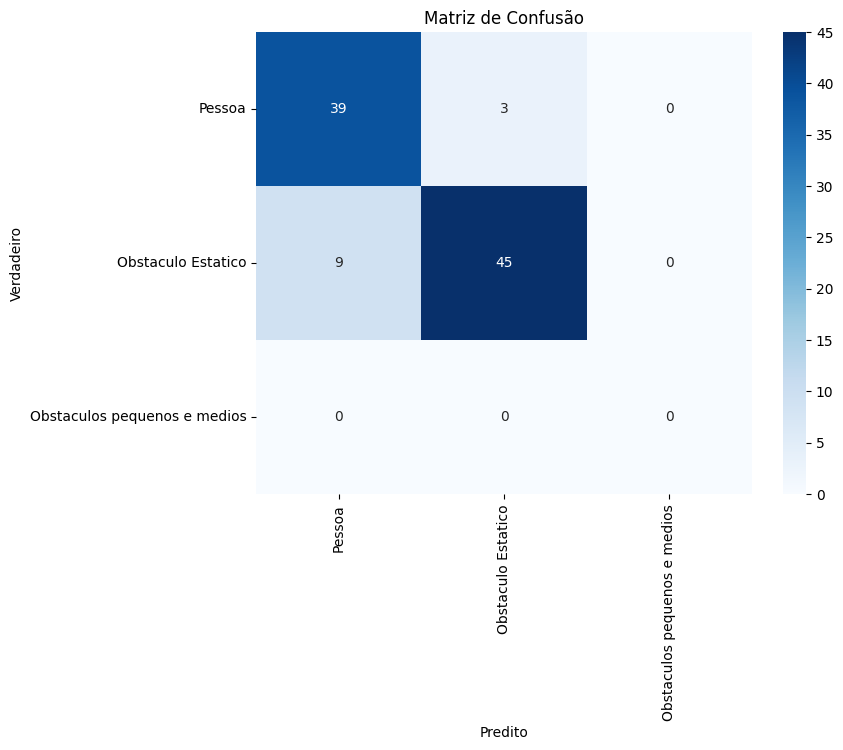

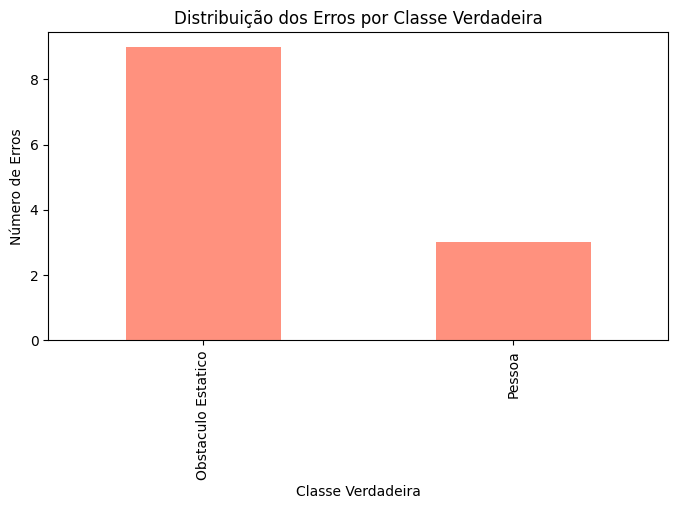

In [89]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=obstacle_types, yticklabels=obstacle_types)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

# Distribuição dos erros
plt.figure(figsize=(8,4))
errors_df['true_label_str'].value_counts().plot(kind='bar', color='tomato', alpha=0.7)
plt.title('Distribuição dos Erros por Classe Verdadeira')
plt.xlabel('Classe Verdadeira')
plt.ylabel('Número de Erros')
plt.show()

# 04_Analise_Textual_Gemini.ipynb

Este notebook utiliza a API Gemini para análise textual interativa dos resultados e erros do modelo multi-feature, com foco em explicações e insights sobre os dados e classificações.

**Passos principais:**
- Montar o Google Drive
- Carregar configuração, métricas, erros e dados de teste
- Configurar a chave da API Gemini de forma segura
- Analisar métricas globais e casos de erro específicos usando Gemini

## Instalar Bibliotecas Necessárias

Execute a célula abaixo para instalar as bibliotecas necessárias para o notebook.

In [46]:
!pip install google-generativeai pandas numpy

## Importar Bibliotecas

## Montar Google Drive
Monte seu Google Drive para acessar os arquivos de configuração, métricas, erros e dados de teste.

## Carregar Configuração e Caminhos
Carregue o arquivo de configuração (project_config.json) e extraia project_base_dir, feature_columns e obstacle_types.

In [48]:
# Defina o caminho do arquivo de configuração
config_path = '/content/drive/MyDrive/SimClasIotIA/project_config.json'

with open(config_path, 'r') as f:
    config = json.load(f)

project_base_dir = config['project_base_dir']
feature_columns = config['feature_columns']
obstacle_types = config['obstacle_types']
print('project_base_dir:', project_base_dir)
print('feature_columns:', feature_columns)
print('obstacle_types:', obstacle_types)

project_base_dir: /content/drive/MyDrive/SimClasIotIA/
feature_columns: ['Distancia', 'Variacao da Distancia', 'Tamanho Percebido', 'Velocidade de Aproximacao', 'Frequencia de Deteccao']
obstacle_types: ['Pessoa', 'Obstaculo Estatico', 'Obstaculos pequenos e medios']


## Definir Nomes de Arquivos
Defina os nomes dos arquivos de entrada e construa os caminhos completos.

In [49]:
metrics_input_filename = 'metrics.json'
errors_input_filename = 'errors.csv'
X_test_filename = 'X_test.npy'
y_test_filename = 'y_test.npy'

data_input_filename = 'simulated_sensor_data.csv'  # Opcional para análise

metrics_input_path = os.path.join(project_base_dir, metrics_input_filename)
errors_input_path = os.path.join(project_base_dir, errors_input_filename)
X_test_path = os.path.join(project_base_dir, X_test_filename)
y_test_path = os.path.join(project_base_dir, y_test_filename)

data_filepath = os.path.join(project_base_dir, data_input_filename)

print('metrics_input_path:', metrics_input_path)
print('errors_input_path:', errors_input_path)
print('X_test_path:', X_test_path)
print('y_test_path:', y_test_path)

metrics_input_path: /content/drive/MyDrive/SimClasIotIA/metrics.json
errors_input_path: /content/drive/MyDrive/SimClasIotIA/errors.csv
X_test_path: /content/drive/MyDrive/SimClasIotIA/X_test.npy
y_test_path: /content/drive/MyDrive/SimClasIotIA/y_test.npy


## Configurar API Key Gemini (Segura)
A chave de API Gemini deve ser salva nos Segredos do Colab com o nome `GEMINI_API_KEY`.

No menu do Colab: `Ambiente de execução` > `Gerenciar segredos` > Adicione `GEMINI_API_KEY`.

## Escolher e Iniciar o Modelo/Chat Gemini

## Carregar Dados da Etapa 3 e 2
Carregue métricas, erros, X_test e y_test.

In [57]:
gemini_model_name = 'gemini-2.0-flash'
chat2 = genai.GenerativeModel(model_name=gemini_model_name).start_chat(history=[])

# Carregar métricas
with open(metrics_input_path, 'r') as f:
    metrics = json.load(f)

# Carregar erros
errors_df = pd.read_csv(errors_input_path)

# Carregar X_test e y_test
X_test = np.load(X_test_path)
y_test = np.load(y_test_path)

print('Métricas carregadas:', list(metrics.keys()))
print('Erros carregados:', errors_df.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

Métricas carregadas: ['accuracy', 'classification_report', 'confusion_matrix', 'obstacle_types']
Erros carregados: (13, 5)
X_test shape: (96, 20, 5)
y_test shape: (96, 2)


## Interação 1: Análise de Métricas Globais com Gemini

In [58]:
# Formatar prompt para análise global
prompt_metrics = f"""
Analisando resultados de um modelo de classificação multivariada de séries temporais com {len(feature_columns)} características do sensor: {feature_columns}.
Métricas globais:
Accuracy: {metrics['accuracy']}

Classification Report:
{json.dumps(metrics['classification_report'], indent=2, ensure_ascii=False)}

Matriz de confusão:
{metrics['confusion_matrix']}

Com base nesses resultados, forneça uma análise textual dos pontos fortes e fracos do modelo, possíveis causas de erro e sugestões para melhoria.
"""

response = chat2.send_message(prompt_metrics)
print('Gemini:', response.text)

Gemini: ## Análise do Modelo de Classificação de Séries Temporais

Os resultados do modelo de classificação multivariada de séries temporais apresentam um desempenho geral bom, mas com algumas áreas que precisam de atenção e melhoria.

**Pontos Fortes:**

*   **Acurácia Global Alta:** A acurácia de 86.46% indica que o modelo está correto na maioria das vezes.
*   **Bom Desempenho para as Classes 'Pessoa' e 'Obstaculo Estatico':** As métricas de precisão, recall e f1-score para essas classes estão boas, sugerindo que o modelo consegue identificar corretamente tanto pessoas quanto obstáculos estáticos com uma boa taxa de sucesso. A precisão acima de 80% para ambas as classes indica que quando o modelo prediz uma classe, ele está correto na maioria das vezes. O recall também alto (acima de 85%) sugere que o modelo identifica uma alta proporção das ocorrências dessas classes.

**Pontos Fracos:**

*   **Problemas Graves com a Classe 'Obstaculos pequenos e medios':** O modelo não consegue id

## Interação 2: Análise de Erros Específicos com Gemini
Para cada erro, envie a sequência multi-feature, rótulo verdadeiro e predito para análise textual.

In [60]:
# Limite de exemplos para evitar excesso de prompts
max_errors_to_analyze = 5

for idx, row in errors_df.head(max_errors_to_analyze).iterrows():
    error_index = int(row['error_index'])
    true_label_str = row['true_label_str']
    pred_label_str = row['pred_label_str']
    error_sequence_data = X_test[error_index]

    # Formatar sequência para string
    sequence_str = json.dumps(error_sequence_data.tolist(), ensure_ascii=False)

    prompt_error_case = f"""
O modelo errou ao classificar uma sequência de sensor.
Características: {feature_columns}
Dados da sequência (tempo por linha): {sequence_str}
Rótulo correto: {true_label_str}
Predição do modelo: {pred_label_str}

Analisando apenas estes dados numéricos multi-feature, quais padrões ou relações entre as características você observa que poderiam ter tornado esta classificação ambígua ou difícil para o modelo? Especule sobre possíveis razões.
"""

    print(f'\n--- Análise do erro {idx+1} ---')
    response = chat2.send_message(prompt_error_case)
    print('Gemini:', response.text)



--- Análise do erro 1 ---
Gemini: Analisando os dados fornecidos e considerando que o modelo errou ao classificar essa sequência como "Obstaculo Estatico" em vez de "Pessoa", podemos especular sobre os possíveis padrões e relações entre as características que podem ter levado a essa confusão. É importante ressaltar que esta é uma análise exploratória baseada em dados limitados.

**Padrões e Relações Observadas:**

1.  **Distância:** A distância varia significativamente ao longo da sequência, com valores tanto positivos quanto negativos. O sinal negativo pode indicar que a distância está diminuindo, ou seja, o objeto está se aproximando. A presença de tanto valores baixos quanto altos pode ser confusa.

2.  **Variação da Distância:** A variação da distância também apresenta flutuações consideráveis, com valores positivos e negativos. Isso indica que o objeto se aproxima e se afasta em diferentes momentos. Essas mudanças podem ocorrer devido a movimentos da pessoa ou a variações na leit